<a href="https://colab.research.google.com/github/ssehztirom/html_css_js/blob/master/BasisVAE_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install the BasisVAE package

In [ ]:
!pip install git+https://github.com/kasparmartens/BasisVAE.git

  Cloning https://github.com/kasparmartens/BasisVAE.git to /tmp/pip-req-build-5yn_4off
  Running command git clone -q https://github.com/kasparmartens/BasisVAE.git /tmp/pip-req-build-5yn_4off
  Created wheel for BasisVAE: filename=BasisVAE-0.1-cp36-none-any.whl size=7117 sha256=375dbb4f39eb823eddcd1fb90587db2f0bd2ed21687dc31d88dfc70ea8d32778
  Stored in directory: /tmp/pip-ephem-wheel-cache-od36u_w8/wheels/9e/01/49/0be9f9f152b2de22430919b12c8441dc57957d6b8a5b969296
Successfully built BasisVAE


Import packages

In [ ]:
import torch
import torch.nn as nn
import numpy as np

from BasisVAE.VAE import VAE
from BasisVAE.decoder import BasisDecoder
from BasisVAE.encoder import Encoder

from torch.utils.data import TensorDataset, DataLoader

Import toy data set

![](https://raw.githubusercontent.com/kasparmartens/BasisVAE/master/fig/toy_data.png)


In [ ]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/kasparmartens/BasisVAE/master/toy_data/toy.csv")

In [ ]:
# set up the PyTorch DataLoader object
Y = torch.Tensor(df.values)
dataset = TensorDataset(Y)
data_loader = DataLoader(dataset, batch_size=32)

Model specification (set up encoder and decoder)

In [ ]:
z_dim = 1
hidden_dim = 128
data_dim = Y.shape[1]

torch.manual_seed(42)

# ENCODER

encoder = Encoder(data_dim, hidden_dim, z_dim)

# DECODER
n_basis = 5
scale_invariance = True
translation_invariance = True

decoder = BasisDecoder(data_dim, hidden_dim, z_dim, n_basis,
                       scale_invariance,
                       translation_invariance,
                       likelihood="Gaussian",
                       nonlinearity = torch.nn.Tanh,
                       #max_delta=2.0,
                       alpha=0.1,
                       inference="collapsed")

model = VAE(encoder, decoder, lr=0.001)

Model fitting

In [ ]:
model.optimize(data_loader, n_epochs=500, logging_freq=10, beta=1.0)

Fitting BasisVAE.
	Scale-invariance=True	Translation-invariance=True

	Data set size 500, batch size 32, number of basis funs 5.

	Epoch:  0. Total loss:   -29385.61
	Epoch: 10. Total loss:   -29738.59
	Epoch: 20. Total loss:   -29638.23
	Epoch: 30. Total loss:   -29730.09
	Epoch: 40. Total loss:   -29768.06
	Epoch: 50. Total loss:   -29826.14
	Epoch: 60. Total loss:   -28901.86
	Epoch: 70. Total loss:   -28640.83
	Epoch: 80. Total loss:   -29275.00
	Epoch: 90. Total loss:   -27819.92
	Epoch: 100. Total loss:   -29846.01
	Epoch: 110. Total loss:   -28830.91
	Epoch: 120. Total loss:   -29079.72
	Epoch: 130. Total loss:   -30658.13
	Epoch: 140. Total loss:   -30675.22
	Epoch: 150. Total loss:   -31010.63
	Epoch: 160. Total loss:   -30366.16
	Epoch: 170. Total loss:   -30807.57
	Epoch: 180. Total loss:   -31242.75
	Epoch: 190. Total loss:   -31326.20
	Epoch: 200. Total loss:   -31479.26
	Epoch: 210. Total loss:   -31646.47
	Epoch: 220. Total loss:   -31722.41
	Epoch: 230. Total loss:   -3

Visualise the approximate posterior of cluster allocation probabilities (basis_functions x features)

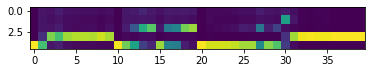

In [ ]:
import matplotlib.pyplot as plt

with torch.no_grad():
    cluster_probs = decoder.get_phi()

plt.imshow(cluster_probs.t())

Inspect the mappings (i.e. predictions learnt by the decoder)

In [ ]:
z_grid = torch.linspace(-2.5, 2.5, steps=100).reshape(-1, 1)

with torch.no_grad():
    Y_pred_all, dropout_logit, theta = model.decoder(z_grid)

Y_pred_all = Y_pred_all.numpy()
w = cluster_probs.numpy()
w_argmax = w.argmax(1)
idx = np.arange(w_argmax.shape[0])

if model.decoder.translation_invariance:
    # pick out delta for the most likely cluster allocation
    delta_z_all = model.decoder.get_delta().detach().numpy()
    delta_z = delta_z_all[idx, w_argmax, :]

# most likely prediction
Y_pred = Y_pred_all[:, idx, w_argmax]

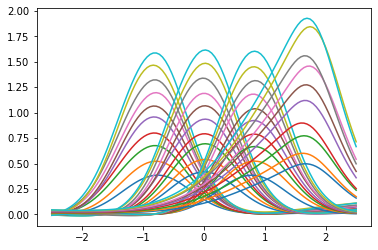

In [ ]:
# very simplistic visualisation (ignoring cluster allocations at the moment)
for j in range(40):
    plt.plot(z_grid.reshape(-1), Y_pred[:, j])